# Setup

In [1]:
# ML algorithms
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.tree import DecisionTreeClassifier

# preprocessing
from sklearn.preprocessing import StandardScaler, Imputer

# evaluation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

# feature reduction
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

# feature calibration
from sklearn.isotonic import IsotonicRegression

# matplotlib
import matplotlib.pyplot as plt

import numpy as np
from numpy import nan

from pprint import pprint

import math
import random

# Functions

In [2]:
# balanced train and test sets
def balance_data(X, y):
    X_bal = []
    y_bal = []
    X_rest = []
    y_rest = []
    min1 = len([tar for tar in y if tar==1])
    min2 = len([tar for tar in y if tar==-1])
    mini = min1
    if min2 < min1:
        mini = min2

    cnt_1 = 0
    cnt_0 = 0
    print(mini)
    for i, tar in enumerate(y):
        if tar == 1 and cnt_1<mini:
            cnt_1+=1
            X_bal.append(X[i])
            y_bal.append(y[i])
        elif tar == -1 and cnt_0<mini:
            cnt_0+=1
            X_bal.append(X[i])
            y_bal.append(y[i])
        elif tar == 0:
            X_bal.append(X[i])
            y_bal.append(y[i])
        else:
            X_rest.append(X[i])
            y_rest.append(y[i])

    print("# X_bal:", len(X_bal))
    print("# y_bal:", len(y_bal))
    print("% compromised: ", len([tar for tar in y_bal if tar==1])/len(y_bal))
    print("% malicious: ", len([tar for tar in y_bal if tar==-1])/len(y_bal))
    print("% unlabeled: ", len([tar for tar in y_bal if tar==0])/len(y_bal))
    
    print("# X_rest:", len(X_rest))
    print("# y_rest:", len(y_rest))
    print("% compromised: ", len([tar for tar in y_rest if tar==1])/len(y_rest))
    print("% malicious: ", len([tar for tar in y_rest if tar==-1])/len(y_rest))
    print("% unlabeled: ", len([tar for tar in y_rest if tar==0])/len(y_rest))
    
    return [X_bal, y_bal, X_rest, y_rest]

# Read data

In [3]:
with open("/home/sophie/SSRG/domainclassification/results/dataset/domain_target_55383", "r", encoding='utf-8') as f:
    data = eval(f.read())
    
random.Random(4).shuffle(data)
    
datasets = set([d['dataset'] for d in data])
pprint(datasets)

{'comp-deltaphish',
 'comp-phishlabs',
 'mal-apwg',
 'mal-future-apwg',
 'mal-phishlabs',
 'unlabeled-apwg'}


In [9]:
# original
feat_labels = data[0]['feat_labels']
print(feat_labels)
print(len(feat_labels))

# remove specific features 'prev_mal_tld', 'prev_mal_domain_ed'
feat_labels = np.concatenate((data[0]['feat_labels'][0:5], data[0]['feat_labels'][6:16], data[0]['feat_labels'][17:19]), axis=0)
print(feat_labels)
print(len(feat_labels))

['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
19
['archived' 'years_active' 'years_inactive' 'num_captures' 'freenom_tld'
 'wildcard_subdomain' 'reachable' 'redirected' 'blocked' 'alexa_rank'
 'ratio_longest_word' 'contain_digit' 'contain_dash' 'name_len'
 'brandname_partialratio' 'sub_levels' 'num_sub']
17


In [20]:
# remove specific features
for d in data:
    feat_temp = d['feat']
    feat_labels = d['feat_labels']
    d['feat'] = feat_temp[0:5] + feat_temp[6:16] + feat_temp[17:19]
    d['feat_labels'] = feat_labels[0:5] + feat_labels[6:16] + feat_labels[17:19]

In [4]:
#random.Random(4).shuffle(data)

#dataset_train = {'mal-apwg', 'comp-deltaphish', 'unlabeled-apwg'}
dataset_train = {'mal-apwg', 'comp-phishlabs', 'unlabeled-apwg'}

X = np.array([d['feat'] for d in data if d['dataset'] in dataset_train])
y = np.array([d['target'] for d in data if d['dataset'] in dataset_train])
data = [d for d in data if d['dataset'] in dataset_train]

feat_labels = data[0]['feat_labels']
print(feat_labels)
print(len(feat_labels))

print(len(data))
print(X.shape)
print(y.shape)
print(feat_labels)
pprint(X[:5])
pprint(y[:5])
print("# compromised: ", len([tar for tar in y if tar==1]))
print("# malicious: ", len([tar for tar in y if tar==-1]))
print("# unknown: ", len([tar for tar in y if tar==0]))
print("% compromised: ", len([tar for tar in y if tar==1])/len(y))
print("% malicious: ", len([tar for tar in y if tar==-1])/len(y))
print("% unknown: ", len([tar for tar in y if tar==0])/len(y))

['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
19
51576
(51576, 19)
(51576,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
array([[0.00000000e+00,            nan,            nan,            nan,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   nan,            nan,            nan, 3.33333333e-01,
        0.00000000e+00, 0.00000000e+00, 1.20000000e+01, 6.70000000e+01,
        8.33333333e-02, 0.00000000e+00, 1.00000000e+00],
       [0

In [50]:
# balance
#X, y, X_val, y_val = balance_data(X, y)

# Normalize and Impute

In [5]:
# imp = Imputer(missing_values=np.nan, strategy='mean')
# imp.fit(X)
# X = imp.transform(X)
X = np.where(np.isnan(X), -1, X)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print(X[2])

[-1.11920933 -0.68645534 -0.80890736 -0.02315445 -0.29762989 -0.2200951
 -0.46933103  0.92116008  0.74077259  0.78517207 -0.15525539  2.80600545
 -0.2985938  -0.4211886  -0.72102866 -0.44826006  0.32710065  0.76978709
 -0.05508077]


# Data calibration

In [36]:
def sortAscendingFeature(cX, cy):
    idx_cX = np.argsort(cX)
    cX = np.array(cX)[idx_cX]
    cy = np.array(cy)[idx_cX]
    return cX, idx_cX, cy

In [37]:
# test
cX = [3,4,5,1,2]
cy = [1,1,1,0,0]
x = sortAscendingFeature(cX,cy)
print(x)
cX, idx_cX, cy = x
idx_cX_sort = np.argsort(idx_cX)
cX = np.array(cX)[idx_cX_sort]
print(idx_cX_sort)
print(cX)

(array([1, 2, 3, 4, 5]), array([3, 4, 0, 1, 2]), array([0, 0, 1, 1, 1]))
[2 3 4 0 1]
[3 4 5 1 2]


In [38]:
def calibratedFeature(cX, cy):
    cX, idx_cX, cy = sortAscendingFeature(cX, cy)
    
    #print(cX[:-20])
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(cX, cy)
    cX = iso.transform(cX)
    #print(cX[:-20])
    
    # sort back to original indexes
    idx_cX_sort = np.argsort(idx_cX)
    cX = np.array(cX)[idx_cX_sort]
    return cX

In [39]:
# calibrated features
cfeatures = {'years_active', 'years_inactive', 'num_captures', 'alexa_rank', 'sub_levels', 'num_sub'}

X_new = np.copy(X)
for i, feat in enumerate(feat_labels):
    if feat in cfeatures:
        cX, cy = X_new[:,i], y
        #print(cX[:50])
        #print(cy[:50])
        cX = calibratedFeature(cX, cy)
        X_new[:, i] = cX

#### Visualize calibrated features

In [40]:
def plotFractionalGraph(x, y=None, xlabel="", xmin=0, xmax=4000):
    ax = plt.subplot()
    ax.plot(x)

    plt.grid(True, linestyle='dotted')
    plt.show()

years_active


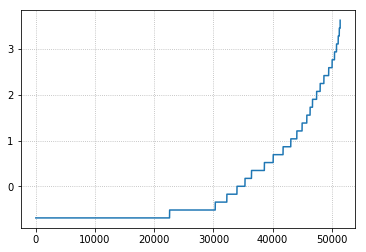

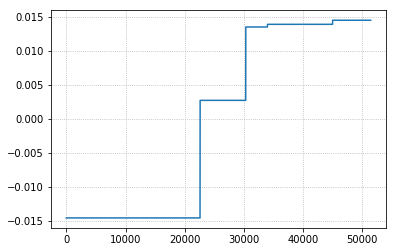

years_inactive


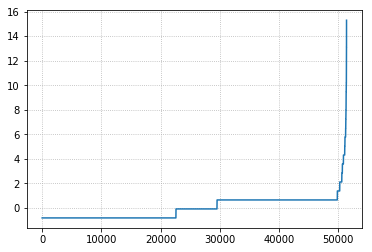

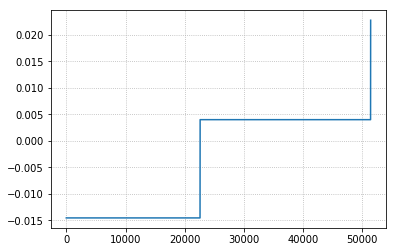

num_captures


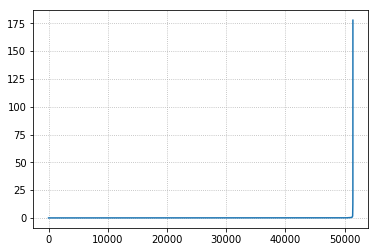

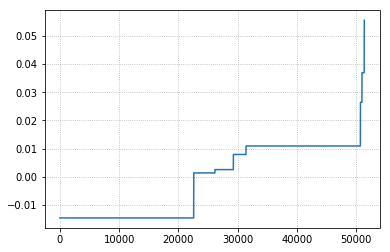

alexa_rank


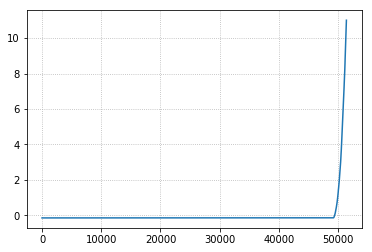

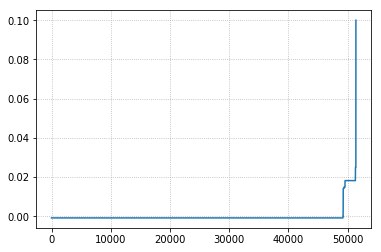

sub_levels


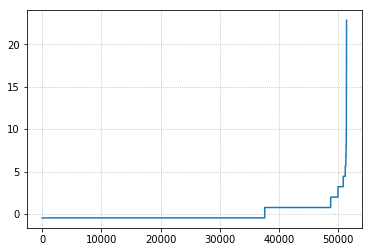

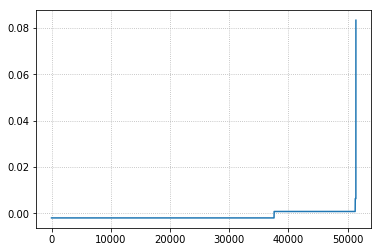

num_sub


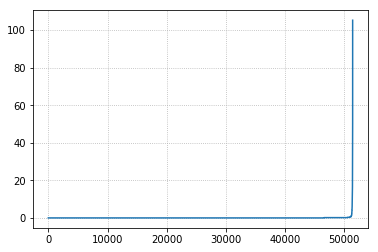

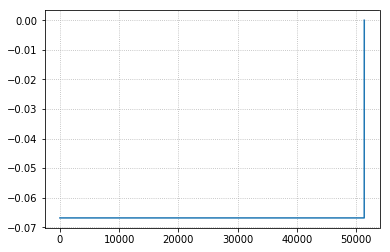

In [41]:
for i, feat in enumerate(feat_labels):
    if feat in cfeatures:
        print(feat)
        # get feat before and after
        feat_before = X[:,i]
        feat_after = X_new[:,i]
        
        # sort feats
        feat_before = np.sort(np.array(feat_before))
        feat_after = np.sort(np.array(feat_after))
        
        plotFractionalGraph(feat_before)
        plotFractionalGraph(feat_after)
        #plt.plot(feat_before)

In [42]:
X = X_new

#### Verify feature relevance

In [24]:
def getAUC(X, y, clf, feat=""):
    clf.fit(X, y)
    y_pred = clf.predict(X)
    acc_train = accuracy_score(y, y_pred)
    return acc_train, feat

In [29]:
clf = DecisionTreeClassifier()
name = "DecisionTreeClassifier()"
print(name)
auc_feat_list = []
print(feat_labels)
paper_feat_labels = feat_labels
for i, feat in enumerate(paper_feat_labels):
    X_temp = X[:,i].reshape(-1, 1)
    auc_feat_list.append(getAUC(X_temp, y, clf, feat))

pprint(auc_feat_list)

DecisionTreeClassifier()
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
[(0.9807400490253297, 'archived'),
 (0.9807400490253297, 'years_active'),
 (0.9807400490253297, 'years_inactive'),
 (0.9807400490253297, 'num_captures'),
 (0.9807400490253297, 'freenom_tld'),
 (0.9807400490253297, 'prev_mal_tld'),
 (0.9807400490253297, 'wildcard_subdomain'),
 (0.9807400490253297, 'reachable'),
 (0.9807400490253297, 'redirected'),
 (0.9807400490253297, 'blocked'),
 (0.9807400490253297, 'alexa_rank'),
 (0.9807400490253297, 'ratio_longest_word'),
 (0.9807400490253297, 'contain_digit'),
 (0.9807400490253297, 'contain_dash'),
 (0.9807400490253297, 'name_len'),
 (0.9807400490253297, 'brandname_partialratio'),
 (0.9807400490253297, 'prev_mal_domain_

In [ ]:
aucs = [x[0] for x in auc_feat_list]
feats = [x[1] for x in auc_feat_list]

fig, ax = plt.subplots()
plt.figure(figsize=(15,10))

# Example data
y_pos = np.arange(len(feats))

ax.barh(y_pos, aucs, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feats)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Area under the curve (AUC)')
ax.set_xlim([0,1])
#ax.set_title('How fast do you want to go today?')

plt.show()

# Data reduction

In [52]:
# To deal with high-dimensional data
def getPCA(X, n_c=10):
    pca = PCA(n_components=n_c, svd_solver='full', random_state=42)
    pca.fit(X) 
    X_pca = pca.transform(X)
    return X_pca
    #print(X_pca[2])

# Cluster

In [6]:
def entropy(prob):
    if prob == 1 or prob == 0:
        return 0
    return -prob*math.log(prob, 2) - (1-prob)*math.log((1-prob), 2)

In [7]:
def getEntropy(pred, pred_label):
    t_total = len(data)
    ent_w = 0

    for pred, labels in pred_label.items():
        neg, pos, unknown = labels[-1], labels[1], labels[0]
        total = neg+pos+unknown
        neg_pr = neg/total
        if total > 0:
            neg_pr = neg/total
        else:
            neg_pr = 0
        
        ent = entropy(neg_pr)
        ent_w += ent*(total/t_total)
    return ent_w

In [8]:
def getCluster(X, n_c=12, name="KMeans"):
    if name == "KMeans":
        clf = KMeans(n_clusters=n_c, random_state=42)
    elif name == "DBSCAN":
        clf = DBSCAN(min_samples=30)
    elif name == "Birch":
        clf = Birch(n_clusters=n_c, threshold=0.5, branching_factor=50)

    pred = clf.fit_predict(X)

    pred_label = dict()
    for i, pr in enumerate(pred):
        label = y[i]
        if pr not in pred_label:
            pred_label[pr] = dict()
            pred_label[pr][0], pred_label[pr][1], pred_label[pr][-1] = 0, 0, 0

        pred_label[pr][label] += 1
        
    return pred_label, pred

In [9]:
def processClusters(pred_label, min_entropy=0.2, min_entity=10):
    cluster_to_label = dict()

    for cluster, labels in pred_label.items():
        neg, pos = labels[-1], labels[1]
        total = neg+pos

        # ignore clusters where max label is less than threshold
        if max(neg, pos) < min_entity:
            continue

        # ignore clusters where entropy is > threshold
        neg_pr = neg/total
        if entropy(neg_pr) > min_entropy:
            continue

        label = 0
        if neg > pos:
            label = -1
        elif neg < pos:
            label = 1

        cluster_to_label[cluster] = label
    return cluster_to_label
    #print(cluster_to_label)

In [10]:
def getNumDomainsAndDomainTypeRatio(pred, cluster_to_label, data, y):

    data_idx_label = []
    for i, pr in enumerate(pred):
        if pr in cluster_to_label:
            label = y[i]
            if label == 0:
                label = cluster_to_label[pr]
                data_idx_label.append([i, label])
                #temp = data[i]
                #temp["target"] = label
                #data_label.append(temp)
    
    #X_cluster = np.array([d['feat'] for d in data_label])
    #y_cluster = np.array([d['target'] for d in data_label])
    
    per_comp, per_mal = 0, 0
    if len(data_idx_label) > 0:
        per_comp = len([x for x in data_idx_label if x[1]==1])/len(data_idx_label)
        per_mal = len([x for x in data_idx_label if x[1]==-1])/len(data_idx_label)
    
    return round(per_comp*100), round(per_mal*100), data_idx_label

In [11]:
# try several hyperparamters
#pca_components = list(range(1,20)) #1-19
#pca_components = list(range(5,11)) #1-19
#pca_components = list(range(12,14)) #1-19
pca_components = [5, 10]
pca_components = [False] + pca_components
trypca = False
if trypca is False:
    pca_components = [0]

#n_clusters = list(range(2,13)) #2-12
#n_clusters = list(range(7,13))
n_clusters = list(range(12,16))

#min_entropy = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
#min_entropy = [0.1, 0.15, 0.2]
min_entropy = [0.25, 0.3, 0.35]

#min_entity = list(range(1,20)) #1-20
#min_entity = list(range(7,11)) #1-20
min_entity = [10]

#orig_X, orig_y = X, y

data_idx_label = dict()
cnt = 0
test = False
print("Number of combinations:", len(pca_components)*len(n_clusters)*len(min_entropy)*len(min_entity))
print(["pca_c", "n_c", "min_ent", "min_e", "per_comp", "per_mal", "num_domains"])
for min_e in min_entity:
    for n_c in n_clusters:
        for min_ent in min_entropy:
            for pca_c in pca_components:
            
                # keep track of combinations
                cnt+=1
                if cnt > 10 and test:
                    continue
                else:
                    print(cnt)
                
                # try reducing dimensions 
                if trypca and pca_c != False:
                    X_pca = getPCA(X, pca_c)
                else:
                    X_pca = X
                #print(X_pca[2])
                
                # get predicted cluster labels
                pred_label, pred = getCluster(X_pca, n_c)
                #pprint(pred_label)
                ent = getEntropy(pred, pred_label)
                
                # only keep clusters with certain entropy and minimum number of entities in cluster
                cluster_to_label = processClusters(pred_label, min_ent, min_e)
                #print(cluster_to_label)
                
                # get resulting number of domains and domain type ratio
                per_comp, per_mal, idx_label = getNumDomainsAndDomainTypeRatio(pred, cluster_to_label, data, y)
                
                # ignore results with too little domains or incorrect ratio
                num_domains = len(idx_label)
                entry = [pca_c, n_c, min_ent, min_e, per_comp, per_mal, num_domains, ent]
                print(entry)
#                 if num_domains < 4000:
#                     ignored.append(entry)
#                 elif per_comp > 80 or per_comp < 50:
#                     ignored.append(entry)
#                 else:
#                     candidate.append(entry)
                idx_label = str(idx_label)
                if idx_label not in data_idx_label:
                    data_idx_label[idx_label] = []
                data_idx_label[idx_label].append(entry)
                    
                print()

Number of combinations: 12
['pca_c', 'n_c', 'min_ent', 'min_e', 'per_comp', 'per_mal', 'num_domains']
1
[0, 12, 0.25, 10, 87, 13, 15638, 0.05399895200988528]

2
[0, 12, 0.3, 10, 87, 13, 15638, 0.05399895200988528]

3
[0, 12, 0.35, 10, 87, 13, 15638, 0.05399895200988528]

4
[0, 13, 0.25, 10, 93, 7, 29340, 0.05250231884333648]

5
[0, 13, 0.3, 10, 93, 7, 29340, 0.05250231884333648]

6
[0, 13, 0.35, 10, 93, 7, 29340, 0.05250231884333648]

7
[0, 14, 0.25, 10, 93, 7, 29124, 0.052839670030149534]

8
[0, 14, 0.3, 10, 94, 6, 32050, 0.052839670030149534]

9
[0, 14, 0.35, 10, 94, 6, 32050, 0.052839670030149534]

10
[0, 15, 0.25, 10, 93, 7, 29582, 0.05247681249449126]

11
[0, 15, 0.3, 10, 93, 7, 29582, 0.05247681249449126]

12
[0, 15, 0.35, 10, 93, 7, 29582, 0.05247681249449126]



In [12]:
print(len(data_idx_label))

5


In [13]:
pprint(list(data_idx_label.values()))

for x in list(data_idx_label.values()):
    num_domains = x[0][6]
    per_mal = x[0][5]
    per_comp = x[0][4]
    
    per_min = min(per_mal, per_comp)
    #diff = per_max-50
    print(num_domains*per_min/100)

[[[0, 12, 0.25, 10, 87, 13, 15638, 0.05399895200988528],
  [0, 12, 0.3, 10, 87, 13, 15638, 0.05399895200988528],
  [0, 12, 0.35, 10, 87, 13, 15638, 0.05399895200988528]],
 [[0, 13, 0.25, 10, 93, 7, 29340, 0.05250231884333648],
  [0, 13, 0.3, 10, 93, 7, 29340, 0.05250231884333648],
  [0, 13, 0.35, 10, 93, 7, 29340, 0.05250231884333648]],
 [[0, 14, 0.25, 10, 93, 7, 29124, 0.052839670030149534]],
 [[0, 14, 0.3, 10, 94, 6, 32050, 0.052839670030149534],
  [0, 14, 0.35, 10, 94, 6, 32050, 0.052839670030149534]],
 [[0, 15, 0.25, 10, 93, 7, 29582, 0.05247681249449126],
  [0, 15, 0.3, 10, 93, 7, 29582, 0.05247681249449126],
  [0, 15, 0.35, 10, 93, 7, 29582, 0.05247681249449126]]]
2032.94
2053.8
2038.68
1923.0
2070.74


# Choose specific hyperparameters after manual checking

In [65]:
def getNumDomainsAndDomainTypeRatioSpecific(pred, cluster_to_label, data, y):

    data_label = []
    for i, pr in enumerate(pred):
        if pr in cluster_to_label:
            label = y[i]
            if label == 0:
                label = cluster_to_label[pr]
                #data_idx_label.append([i, label])
                temp = data[i]
                temp["target"] = label
                data_label.append(temp)
    
    X_cluster = np.array([d['feat'] for d in data_label])
    y_cluster = np.array([d['target'] for d in data_label])
    
    per_comp, per_mal = 0, 0
    if len(data_idx_label) > 0:
        per_comp = len([x for x in y_cluster if x==1])/len(y_cluster)
        per_mal = len([x for x in y_cluster if x==-1])/len(y_cluster)
    
    return data_label, round(per_comp*100), round(per_mal*100)

In [66]:
#X_pca = getPCA(X, n_c=12)
X_pca = X
X_pca, n_c, min_ent, min_e = X_pca, 15, 0.1, 10
#73, 27, 19195, 0.053659451762850106],
#[0, 15, 0.1, 10, 64, 36, 5744, 0.05247681249449126]

# get predicted cluster labels
pred_label, pred = getCluster(X_pca, n_c)
#pprint(pred_label)
ent = getEntropy(pred, pred_label)
print(ent)

# only keep clusters with certain entropy and minimum number of entities in cluster
cluster_to_label = processClusters(pred_label, min_ent, min_e)
#print(cluster_to_label)

# get resulting number of domains and domain type ratio
data_label, per_comp, per_mal = getNumDomainsAndDomainTypeRatioSpecific(pred, cluster_to_label, data, y)
print(len(data_label))
print(per_comp)
print(per_mal)

0.05247681249449126
5744
64
36


In [67]:
with open('./data/data_cluster_5744', 'w', encoding="utf-8") as fout:
    pprint(data_label, fout)

# Cluster Analysis

In [15]:
#n_clusters = [2,3,4,5,6,7,8,9,10,11,12]
n_clusters = [2]
#n_c = 5
for n_c in n_clusters:
    print("n_clusters:", n_c)
    clf = KMeans(n_clusters=n_c)
    pred = clf.fit_predict(X)

    pred_label = dict()
    pred_data = dict()
    for i, pr in enumerate(pred):
        label = y[i]
        dt = data[i]
        if pr not in pred_label:
            pred_label[pr] = dict()
            pred_label[pr][0] = 0
            pred_label[pr][1] = 0
            pred_label[pr][-1] = 0
            
            pred_data[pr] = dict()
            pred_data[pr][0] = []
            pred_data[pr][1] = []
            pred_data[pr][-1] = []

        pred_label[pr][label] += 1
        pred_data[pr][label].append(dt)

    print(pred_label)
    print("entropy:", getEntropy(pred, pred_label))
    print()

n_clusters: 2
{1: {0: 69, 1: 383, -1: 14191}, 0: {0: 420, 1: 103, -1: 11811}}
entropy: 0.12144051983185408



In [28]:
x = [x['info'][0] for x in pred_data[0][1]]
for xx in x:
    print(xx)

account-services-login.net
ackermanproduction.com
activerecoveryinc.cf
addarpluss.com
administartingserv.online
ahaofunweb.com
amservers.fr
antseducati.com
attvalidated.com
banauws.com
careerx.cf
casa-davinci.mn
caucasiana.ge
caughtoncamera.co.za
cazanele-dunarii.ro
cdnusercontent.men
centrul2sibiu.ro
cleanday34.ru
clearfieldcountydemocrats.com
com-app.eu
compraonline14.com.ar
constcarte-updates.com
contact-apple.com.br
contemporarympreg.net
cryptoga.org
denise-thibault.com
depositeagency.online
edgnuunfit.com
ekoservis.in.ua
enovadese.tk
etyu-mimon.com
fromevalleywindowcleaning.co.uk
fromnowon.eu
ghandinku.com
ginphed.com.ng
godadogixc.com
gottfried-weiss.online
gw-siegen.us
help-mnhbvgyfty.ga
help-robinettegosselin.net
iban-naambevestigen.website
id-icloud-nnsms.com
iflixes.gq
inversoresasociados.com.bo
ios-sign-in.us
jasdbseywion.com
johnson-industrlal.com
justinso.ga
kjcdzi.com
langitterbelahbalik.com
latina.com.es
lawyerparalegalservices.com
linkatel.gt
linked-buyers.com
mafiathre

In [26]:
#pprint([x['info'][0] for x in pred_data[1][0] if x['feat'][7] == 1])
pprint([x['info'][0] for x in pred_data[0][1]])

['3utilities.com',
 'appleidsecuritys.com',
 'appliancesty.date',
 'at0.win',
 'automobilesbuy.pw',
 'beautyitems.xyz',
 'bounceme.net',
 'buycamera.date',
 'buytools.pw',
 'buytoolse.site',
 'camillebirrell.site',
 'canbeauty.date',
 'carmeelbrmeente.site',
 'carpartsnet.men',
 'carpetstore.pw',
 'carpetstores.xyz',
 'catherinewylde.site',
 'cedricbacon.site',
 'cheaptoyget.date',
 'culinarygoodst.trade',
 'ddns.net',
 'ddnsking.com',
 'dekinsore.online',
 'discountmany.site',
 'eprtmanpower.com',
 'euesshop.top',
 'furnituresy.trade',
 'getwood.date',
 'glassesscarf.date',
 'goodshouse.men',
 'goodsshop.win',
 'homemachine.xyz',
 'homeresjob.men',
 'humphreyjulius.site',
 'imcreator.com',
 'inhomething.men',
 'inthebedst.date',
 'itursulogalvan.edu.mx',
 'jewelryshops.trade',
 'joyviolet.site',
 'jpanbest.win',
 'kimonodress.date',
 'kitchentask.xyz',
 'kitchenget.pw',
 'kitchentooly.date',
 'machinelive.xyz',
 'manydiscount.site',
 'menshoesly.trade',
 'modelshop.pw',
 'motormeet.me